In [20]:
pip install pyextremes

In [21]:
import numpy as np
import scipy.stats as st
import pyextremes
from pyextremes import EVA
from pyextremes.plotting import (
    plot_probability,
    plot_return_values,
    pyextremes_rc,
)
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import pandas as pd
import warnings

warnings.filterwarnings('ignore')


def fevd(amax_values):
    '''
        Fit a generalized extreme value (GEV) to the flow rate (Q) data

        Inputs:
            amax_values (pandas DataFrame): Annual maximum flow rates

        Returns:
            model: Generalized extreme value model
            shape: Shape parameter of distribution
            loc: Location parameter of distribution
            scale: Scale parameter of distribution
    '''

    # Convert data to required format

    data = pd.Series(amax_values['Q'].values, index=pd.to_datetime(amax_values.index, format='%Y', exact=True))

    days = pd.to_timedelta(f'{365}D')

    # Initialise an extreme value analysis (EVA) model

    model = EVA(data)

    # Extract extreme values from time series

    s = model.get_extremes(method="BM", block_size=days, errors='ignore')  # BM - Block Maxima method

    # Get initial guess for location and scale

    params = gumbel_r.fit(amax_values['Q'].values)

    # Fit a general extreme value (GEV) to the flow rate (Q) data

    shape, loc, scale = gev.fit(amax_values['Q'].values, loc=params[0], scale=params[1], method='MLE')

    s = model.fit_model(model='MLE', distribution='genextreme', distribution_kwargs={"floc": loc,
                                                                                     "fscale": scale})  # MLE - Maximum Likelihood Estimate model

    return model, shape, loc, scale


def density_data(amax_values, model):
    '''
        Generate data for modelled and empirical data density plot

        Inputs:
            amax_values (pandas DataFrame): Annual maximum flow rates
            model: Generalized extreme value model

        Returns:
            points_emp (numpy array): Points for empirical density plot
            Empirical_density (numpy array): Empirical density values
            points_mod (numpy array):  Points for modelled density plot
            model_density (numpy array): Model density values
            num_samples_density (scalar): Number of samples for density plot
            bw (scalar): bandwidth for density plot
    '''

    # Convert data to required format

    data = pd.Series(amax_values['Q'].values, index=pd.to_datetime(amax_values.index, format='%Y', exact=True))

    # Set parameters for density plot

    num_samples_density = 100  # Number of samples for density plot

    # Left and right points of the grid at which the density is to be estimated
    # are -/+ (cut*bandwidth) outside of the range of values (lower and upper limits)
    cut = 3

    # Calculate bandwidth for density plot using Silverman's rule of thumb

    n = data.shape[0]
    IQR = np.subtract.reduce(np.percentile(data.values, [75, 25]))
    A = min(np.std(data.values), IQR / 1.349)
    bw = 0.9 * A * n ** (-1 / 5.)

    # Generate points for empirical density plot

    points_emp = np.linspace(model.extremes.min() - cut * bw,
                             model.extremes.max() + cut * bw, num_samples_density)

    # Estimate the empirical density function using gaussian kernel

    kde = KernelDensity(kernel='gaussian',
                        bandwidth=bw).fit(data.values.reshape(-1, 1))
    log_dens = kde.score_samples(points_emp[:, np.newaxis])
    empirical_density = np.exp(log_dens)

    # Generate points for modelled density plot

    points_mod = np.linspace(model.extremes.min() - cut * bw,
                             model.extremes.max() + cut * bw, 100)

    # Estimate the modelled density function using gaussian kernel

    model_density = model.model.pdf(model.extremes_transformer.transform(points_mod))

    return points_emp, empirical_density, points_mod, model_density, num_samples_density, bw


def get_qq_data(data, shape, loc, scale):
    """
        Generate data for QQ (Quantile-Quantile) plot between empirical and fitted data.

        Inputs:
            shape (scalar): Shape parameter of distribution
            loc (scalar): Location parameter of distribution
            scale (scalar): Scale parameter of distribution

        Returns:
            x (numpy array): Fitted data
            y (numpy array): Empirical data
    """
    distr = st.genextreme(shape,
                          loc=loc,
                          scale=scale)
    y = np.sort(data)

    N = len(y)

    x = np.arange(1, N + 1) / (N + 1)

    x = distr.ppf(x)

    return x, y


def get_qq2_data(empirical_data, data, shape, loc, scale):
    """
        Generate data for QQ2 (Quantile-Quantile) plot between simulated data and empirical data.

        Inputs:
            shape: Shape parameter of distribution
            loc: Location parameter of distribution
            scale: Scale parameter of distribution

        Returns:
            empirical_data: Empirical data
            simulated_data: Model simulated data
            x_val: x values for regression line between simulated and empirical data
            y_val: y values for regression line between simulated and empirical data
    """

    # Generate gev distribution based on calculated parameters

    distr = st.genextreme(shape,
                          loc=loc,
                          scale=scale)

    # Get random samples

    simulated_data = distr.rvs(size=data.shape[0])
    simulated_data = np.sort(simulated_data)

    # Regression line

    x_val = np.linspace(0, empirical_data.max(), 100)  # x points to calculate for regression
    p = np.polyfit(empirical_data, simulated_data, 1)  # Fit line to data
    y_val = np.polyval(p, x_val)  # Calculated y values for regression

    return empirical_data, simulated_data, x_val, y_val

def plot_return_values_example(model, ax, return_periods, alpha, num_samples_return):
    model.plot_return_values(
        ax=ax,
        return_period=return_periods,
        alpha=alpha,
        n_samples=num_samples_return,
        return_period_size='365D'
    )
    ax.set_xlabel('Return Period (years)')
    ax.set_ylabel('Return Level')
    ax.grid(False, which="both")


def plot_all(amax_values, model, shape, loc, scale, save_figure=False, filename='data_plot.png'):
    '''
        Produces a 2x2 plot to characterise the GEV model:
            Top left : Quantile (Q-Q) plot between empirical data versus modelled data
            Top right : Quantile (Q-Q2) plot between simulated data versus empirical data
            Bottom left : Density plot for empirical and modelled data
            Bottom right : Return level plot

        Inputs:
            amax_values (pandas DataFrame): Annual maximum flow rates
            model: Generalized extreme value model
            shape: Shape parameter of distribution
            loc: Location parameter of distribution
            scale: Scale parameter of distribution
            save_figure: Set to True to save figure
            filename: Name of figure file

        Returns:
            None
    '''

    # Generate QQ data

    model_qq, empirical_qq = get_qq_data(amax_values['Q'], shape, loc, scale)

    # Generate QQ2 data

    empirical_qq2, model_qq2, x_val, y_val = get_qq2_data(empirical_qq, amax_values['Q'], shape, loc, scale)

    # Get modelled and empirical density data

    points_emp, empirical_density, points_mod, model_density, num_samples_density, bw = density_data(amax_values, model)

    # Create and style figure for plotting

    figsize = (10, 10)
    with plt.rc_context(rc=pyextremes_rc):
        fig, ax = plt.subplots(nrows=2, ncols=2,
                               figsize=figsize, dpi=96,
                               gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
        ax = ax.flatten()

    # Generate QQ plot

    ax[0].scatter(model_qq, empirical_qq, facecolor='none', edgecolors='k')
    low_lim = np.min([model_qq, empirical_qq]) * 0.95
    high_lim = np.max([model_qq, empirical_qq]) * 1.05
    ax[0].plot([low_lim, high_lim], [low_lim, high_lim], c='k')
    ax[0].set_xlim(low_lim, high_lim)
    ax[0].set_ylim(low_lim, high_lim)
    ax[0].set_ylabel('Empirical Quantiles')
    ax[0].set_xlabel('Model Quantiles')

    # Generate QQ2 plot

    low_lim = np.min([empirical_qq2, model_qq2])
    high_lim = np.max([empirical_qq2, model_qq2])
    ax[1].scatter(empirical_qq2, model_qq2,
                  facecolor='black', edgecolors='k', label='_nolegend_')
    ax[1].plot(x_val, y_val, 'b', label='Regression line')

    ax[1].plot([low_lim, high_lim], [low_lim, high_lim], c='k', label='1-1 line')
    ax[1].set_xlabel('Empirical Quantiles')
    ax[1].set_ylabel('Quantiles from Model Simulated Data')
    ax[1].legend()

    # Generate density plot

    ax[2].grid(False)
    ax[2].set_title("Density plot")
    ax[2].set_ylabel("Density")
    ax[2].set_xlabel(f'N = {num_samples_density} , Bandwidth = {bw:.3f}')
    ax[2].plot(points_emp, empirical_density, 'k')
    ax[2].plot(points_mod, model_density, 'b--')
    ax[2].legend(['Empirical', 'Modeled'])

    # Generate return level plot

    return_periods = np.array([2, 5, 10, 20, 50, 100,
                               200, 300, 500, 800])  # Specify return periods in years
    alpha = 0.95  # Confidence interval (0, 1)
    num_samples_return = 100  # Number of samples for bootstrap to calculate confidence intervals

    """model.plot_return_values(ax=ax[3], return_period=return_periods, alpha=alpha,
                             n_samples=num_samples_return, return_period_size='365D')"""

    plot_return_values_example(model, ax[3], return_periods, alpha, num_samples_return)

    #ax[3].set_xlabel('Return Period (years)')
    #ax[3].set_ylabel('Return Level')
    #ax[3].grid(False, which="both")

    # Print return values, upper and lower intervals

    summary = model.get_summary(
        return_period=return_periods,
        alpha=alpha,
        n_samples=num_samples_return)

    print(summary)

    ax[3].set_ylim(-1, np.max(summary['return value'].values) * 3)

    # Save figure

    if save_figure == True:
        plt.savefig(filename, format='png', bbox_inches='tight', dpi=900)


Raw data head:
             0                             1  \
0         file                     timestamp   
1     database                            id   
2     database                          name   
3      station                            id   
4      station                          name   
5      station                 gridReference   
6      station            descriptionSummary   
7      station            descriptionGeneral   
8      station  descriptionStationHydrometry   
9      station         descriptionFlowRecord   
10     station          descriptionCatchment   
11    dataType                            id   
12    dataType                          name   
13    dataType                     parameter   
14    dataType                         units   
15    dataType                        period   
16    dataType               measurementType   
17        data                         first   
18        data                          last   
19  1991-08-10           

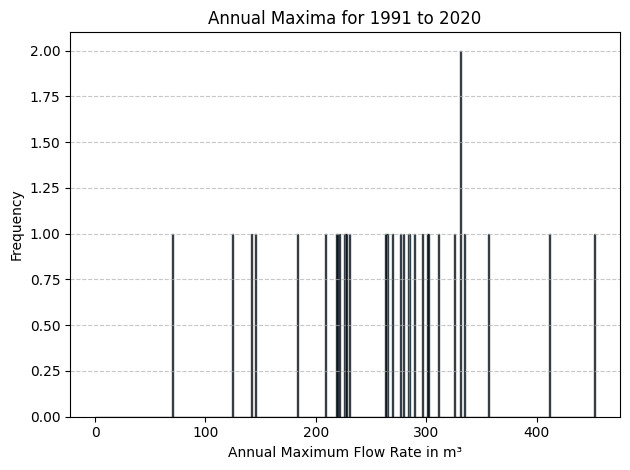

Histogram Data for 1991 to 2020:
   year      Q
0  1991   70.0
1  1992  289.0
2  1993  264.0
3  1994  334.0
4  1995  301.0

Return Periods for 1991 to 2020:
Return Period: 2 years, Return Level: 252.131, 95% CI: (223.024, 283.426)
Return Period: 5 years, Return Level: 346.036, 95% CI: (308.621, 379.826)
Return Period: 10 years, Return Level: 408.209, 95% CI: (356.139, 450.728)
Return Period: 20 years, Return Level: 467.848, 95% CI: (396.671, 520.409)
Return Period: 50 years, Return Level: 545.043, 95% CI: (451.176, 611.728)
Return Period: 100 years, Return Level: 602.891, 95% CI: (489.179, 679.084)


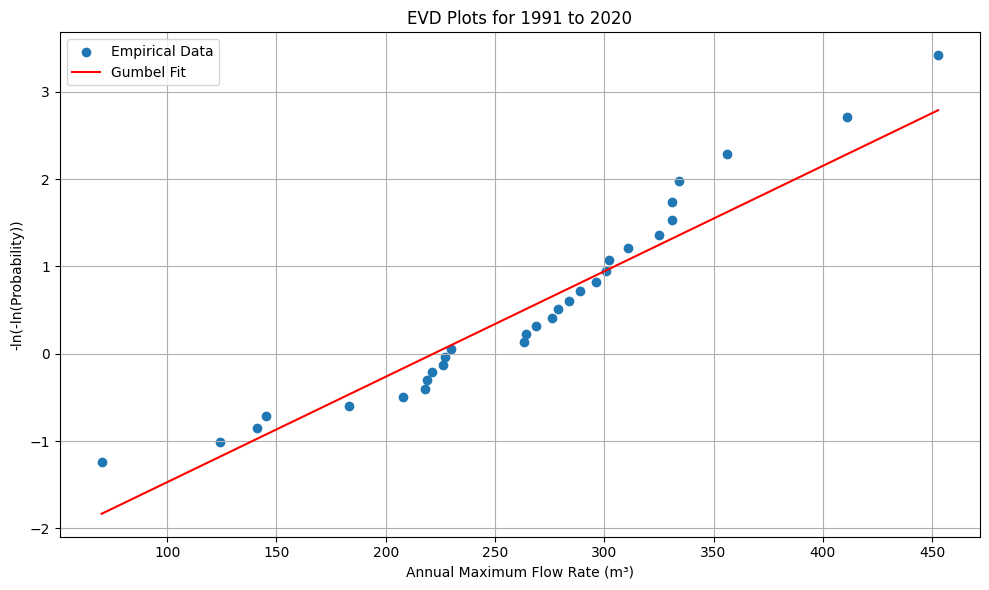

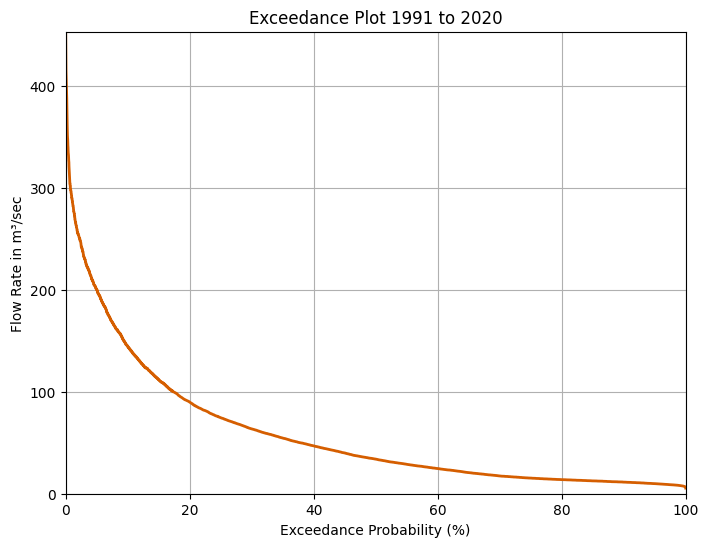

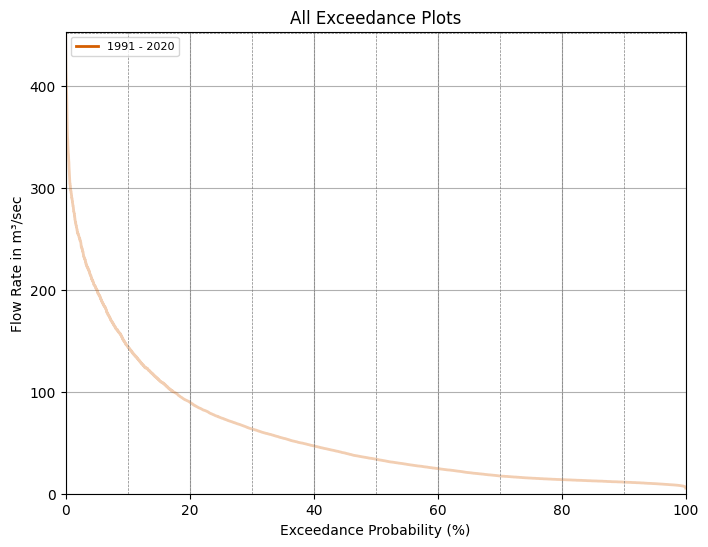

            Q95   Q90     Q10    Q05
1991-2020  9.87  11.4  144.15  200.0


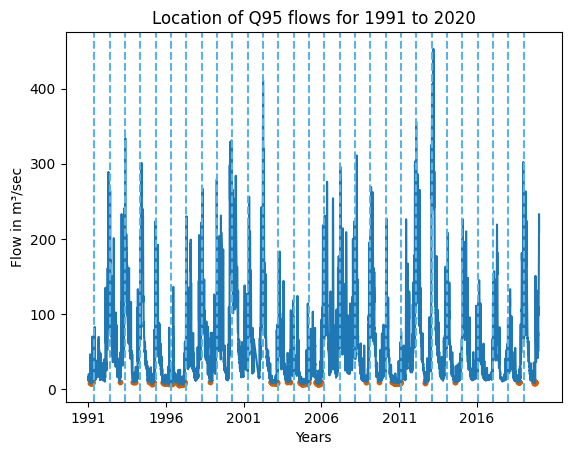

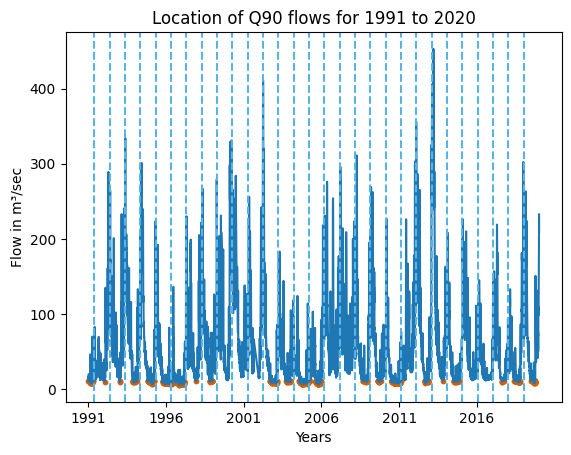

For 1991 to 2020:
     Minimum Peak Flow Rate  Return Period/Yrs
0                     253.0               2.02
1                     254.0               2.04
2                     255.0               2.06
3                     256.0               2.09
4                     257.0               2.11
..                      ...                ...
437                   690.0             285.23
438                   691.0             288.69
439                   692.0             292.19
440                   693.0             295.73
441                   694.0             299.32

[442 rows x 2 columns]


In [24]:
import os
import pandas as pd

# Set working directory to the current directory
#current_dir = os.getcwd()
#print(f"Current Directory: {current_dir}")

# Color-blind palette for plots
cb8 = ["#D55E00", "#56B4E9", "#009E73", "#E69F00", "#F0E442", "#0072B2", "#CC79A7", "#000000"]

# Read the CSV file (make sure the file is in the current directory)
#Change the directory to the directory where your files is saved
csv_file = os.path.join(r"/39121_gdf.csv")
raw_data = pd.read_csv(csv_file, header=None)  # No header specified, as the R code processes the header manually

# Check the first few rows
print("Raw data head:")
print(raw_data.head(25))  # Look at the first 25 rows to identify where the data starts

# The first true line of data is at the 21st line (index 20 since Python is zero-indexed)
data_start_line = 20

# Extract the data starting from the 21st line
the_data = raw_data.iloc[data_start_line:, [0, 1]].reset_index(drop=True)

# Rename columns for clarity
the_data.columns = ["date", "Q"]

# Add the "year" column by extracting the first 4 characters of the "date" column
the_data["year"] = the_data["date"].str[:4].astype(int)

# Convert "Q" column to numeric, coercing errors to NaN for proper handling of missing data
the_data["Q"] = pd.to_numeric(the_data["Q"], errors="coerce")

# Deal with NAs (missing data points):
# Replace the first NA value (if it exists) with the first non-NA value
if pd.isna(the_data.loc[0, "Q"]):
    first_non_na_index = the_data["Q"].first_valid_index()
    the_data.loc[0:first_non_na_index - 1, "Q"] = the_data.loc[first_non_na_index, "Q"]

# Replace the last NA value (if it exists) with the last non-NA value
if pd.isna(the_data.loc[the_data.index[-1], "Q"]):
    last_non_na_index = the_data["Q"].last_valid_index()
    the_data.loc[last_non_na_index + 1:, "Q"] = the_data.loc[last_non_na_index, "Q"]

# Interpolate remaining NA values using linear interpolation
the_data["Q"] = the_data["Q"].interpolate(method="linear")

# View the cleaned data
print("Cleaned data head:")
print(the_data.head())

print("Cleaned data tail:")
print(the_data.tail())


# Now you want to automatically find 30year sections at 10year intervals
# Define parameters
the_gap = 10  # Gap between sections
the_length = 30  # Length of each section

# Find unique years
unique_years = sorted(the_data["year"].unique())

# Find section ends and starts
ends = [y for y in (unique_years[the_length - 1] + i * the_gap for i in range(11)) if y <= max(unique_years)]
starts = [end - (the_length - 1) for end in ends]

print("Start years:", starts)
print("End years:", ends)

# Create lists to store the data sections and their maximum Q values
data_list = []
max_list = []

# Loop through each start and end year to create data sections
for start, end in zip(starts, ends):
    # Filter the data for the current 30-year section
    section_data = the_data[(the_data["year"] >= start) & (the_data["year"] <= end)]
    data_list.append(section_data)

    # Find the maximum Q value in the section
    max_q = section_data["Q"].max()
    max_list.append(max_q)

# Print the results
for i, (start, end) in enumerate(zip(starts, ends)):
    print(f"Section {i + 1}: {start} to {end}")
    print(f"Max Q: {max_list[i]}")
    print(f"Data:\n{data_list[i].head()}\n")

###### Histogram plots ##########

import matplotlib.pyplot as plt
import numpy as np

# Overall maximum value
the_max = max(max_list)  # Maximum value across all sections
print(f"Overall Maximum Flow Rate: {the_max}")

# Initialize list to store histogram data
the_hists = []

# Plot histograms for each data period
for i, (start, end) in enumerate(zip(starts, ends)):
    # Aggregate: Find the maximum "Q" for each year in the current data section
    hist_data = data_list[i].groupby("year")["Q"].max().reset_index()
    the_hists.append(hist_data)  # Store the aggregated data for later use

    # Generate histogram
    plt.hist(
        hist_data["Q"],
        bins=np.arange(0, np.floor(the_max) + 2),  # Use bins from 0 to the_max (inclusive)
        edgecolor="black",
        alpha=0.7,
    )
    plt.xlabel("Annual Maximum Flow Rate in m³")
    plt.ylabel("Frequency")
    plt.title(f"Annual Maxima for {start} to {end}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show and save each histogram
    plt.show()

    # Uncomment the following line if you'd like to save the plots
    # plt.savefig(f"Histogram_{start}_{end}.png", dpi=300)

# Print the histogram data for reference
for i, (start, end) in enumerate(zip(starts, ends)):
    print(f"Histogram Data for {start} to {end}:\n{the_hists[i].head()}\n")


########## Return Period and their Confidence Limits#############

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r

# Return periods to calculate
return_periods = [2, 5, 10, 20, 50, 100]


# Function to calculate confidence intervals for return levels
def calculate_confidence_intervals(data, return_periods, confidence=0.95):
    # Fit Gumbel distribution to the data
    params = gumbel_r.fit(data)
    location, scale = params

    # Calculate return levels
    probabilities = 1 - (1 / np.array(return_periods))
    return_levels = gumbel_r.ppf(probabilities, loc=location, scale=scale)

    # Approximate confidence intervals using bootstrap
    n_bootstrap = 1000  # Number of bootstrap samples
    bootstrap_samples = np.random.choice(data, size=(n_bootstrap, len(data)), replace=True)
    bootstrap_return_levels = []

    for sample in bootstrap_samples:
        params_boot = gumbel_r.fit(sample)
        bootstrap_return_levels.append(gumbel_r.ppf(probabilities, *params_boot))

    bootstrap_return_levels = np.array(bootstrap_return_levels)
    lower_bounds = np.percentile(bootstrap_return_levels, (1 - confidence) / 2 * 100, axis=0)
    upper_bounds = np.percentile(bootstrap_return_levels, (1 + confidence) / 2 * 100, axis=0)

    return return_levels, lower_bounds, upper_bounds, params


# Loop through histograms and calculate return periods and confidence intervals
for i, hist_data in enumerate(the_hists):
    annual_max_flows = hist_data["Q"].values  # Extract annual max flows

    # Fit Gumbel distribution and calculate return periods
    return_levels, lower_bounds, upper_bounds, params = calculate_confidence_intervals(
        annual_max_flows, return_periods
    )

    # Print results
    print(f"Return Periods for {starts[i]} to {ends[i]}:")
    for j, rp in enumerate(return_periods):
        print(
            f"Return Period: {rp} years, Return Level: {return_levels[j]:.3f}, "
            f"95% CI: ({lower_bounds[j]:.3f}, {upper_bounds[j]:.3f})"
        )

    # Plot the Gumbel fit and return periods
    sorted_flows = np.sort(annual_max_flows)
    empirical_probabilities = (np.arange(1, len(sorted_flows) + 1)) / (len(sorted_flows) + 1)
    theoretical_probabilities = gumbel_r.cdf(sorted_flows, loc=params[0], scale=params[1])

    plt.figure(figsize=(10, 6))
    plt.scatter(sorted_flows, -np.log(-np.log(empirical_probabilities)), label="Empirical Data")
    plt.plot(
        sorted_flows,
        -np.log(-np.log(theoretical_probabilities)),
        label="Gumbel Fit",
        color="red",
    )
    plt.xlabel("Annual Maximum Flow Rate (m³)")
    plt.ylabel("-ln(-ln(Probability))")
    plt.title(f"EVD Plots for {starts[i]} to {ends[i]}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

################################# flow duration curve #######################################

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data_list' contains pandas DataFrames for each period
# Assuming 'cb8' contains the color palette (same as in the R code)
#cb8 = ['#D55E00', '#56B4E9', '#009E73']  # Adjust this to match the colors you want
cb8 = ["#D55E00", "#56B4E9", "#009E73", "#E69F00", "#F0E442", "#0072B2", "#CC79A7", "#000000"]

# Assuming 'the_max' is the maximum value of the flow rate
the_max = max([data.iloc[:, 1].max() for data in
               data_list])  # Get the overall max flow rate using .iloc to access the second column

# Loop over each period in data_list
for i in range(len(data_list)):
    # Extract the flow data for the i-th period
    flow_data = data_list[i].iloc[:, 1].values  # Use .iloc to get the second column (flow data)

    # Sort the flow data in ascending order
    sorted_flow_data = np.sort(flow_data)

    # Calculate the exceedance probability (percentage)
    exceedance_prob = 100 * (np.arange(len(sorted_flow_data), 0, -1) / len(sorted_flow_data))

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(exceedance_prob, sorted_flow_data, color=cb8[i], linewidth=2)

    # Add grid lines and labels
    plt.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    plt.title(f"Exceedance Plot {starts[i]} to {ends[i]}")
    plt.xlabel("Exceedance Probability (%)")
    plt.ylabel("Flow Rate in m³/sec")
    plt.xlim(0, 100)
    plt.ylim(0, the_max)
    plt.grid(True)

    # Show the plot
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming 'data_list' contains pandas DataFrames for each period
# Assuming 'cb8' contains the color palette (same as in the R code)
#cb8 = ['#D55E00', '#56B4E9', '#009E73']  # Adjust this to match the colors you want
cb8 = ["#D55E00", "#56B4E9", "#009E73", "#E69F00", "#F0E442", "#0072B2", "#CC79A7", "#000000"]

# Assuming 'the_max' is the maximum value of the flow rate
the_max = max([data.iloc[:, 1].max() for data in data_list])  # Get the overall max flow rate using .iloc to access the second column

# Create the initial plot (empty)
plt.figure(figsize=(8, 6))
plt.xlim(0, 100)
plt.ylim(0, the_max)
plt.xlabel("Exceedance Probability (%)")
plt.ylabel("Flow Rate in m³/sec")
plt.title("All Exceedance Plots")

# Loop over each period in data_list and plot on the same axis
for i in range(len(data_list)):
    # Extract the flow data for the i-th period
    flow_data = data_list[i].iloc[:, 1].values  # Use .iloc to get the second column (flow data)

    # Sort the flow data in ascending order
    sorted_flow_data = np.sort(flow_data)

    # Calculate the exceedance probability (percentage)
    exceedance_prob = 100 * (np.arange(len(sorted_flow_data), 0, -1) / len(sorted_flow_data))

    # Plot each period's data with transparency (alpha) for overlay effect
    plt.plot(exceedance_prob, sorted_flow_data, color=cb8[i], alpha=0.3, linewidth=2)

    # Add grid lines for better clarity
    plt.axhline(y=2 * np.floor(the_max / 2), color='grey', linestyle='--', linewidth=0.5)
    for x in 10 * np.arange(11):  # Vertical grid lines at intervals of 10
        plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)

# Add custom legend handles to match the colors of the lines
the_times = [f"{starts[i]} - {ends[i]}" for i in range(len(starts))]

# Create custom legend handles using Line2D
legend_handles = [Line2D([0], [0], color=cb8[i], lw=2) for i in range(len(starts))]

# Add the legend with the custom handles
plt.legend(legend_handles, the_times, loc='upper left', fontsize=8)

# Show the plot
plt.grid(True)
plt.show()


#####################Q Flows Any other Q level can be obtained by adjusting the values in the code
import numpy as np
import pandas as pd

# Assuming 'data_list' contains pandas DataFrames for each period
# 'starts' and 'ends' are the start and end years for each period
# Example: starts = ['1969', '1979', '1989'], ends = ['1998', '2008', '2018']

# Define the percentiles you want to calculate
percentiles = [5, 10, 90, 95]  # These correspond to Q95, Q90, Q10, Q05

# Create an empty list to store the results
q_list = []

# Loop over each period in data_list
for i in range(len(data_list)):
    # Extract the flow data for the i-th period
    flow_data = data_list[i].iloc[:, 1].values  # Use .iloc to get the second column (flow data)

    # Sort the flow data in ascending order
    sorted_flow_data = np.sort(flow_data)

    # Calculate the desired percentiles (Q95, Q90, Q10, Q05)
    q_values = np.percentile(sorted_flow_data, percentiles)

    # Append the results to the list
    q_list.append(q_values)

# Create a DataFrame from the results
q_tab = pd.DataFrame(q_list, columns=["Q95", "Q90", "Q10", "Q05"],
                     index=[f"{starts[i]}-{ends[i]}" for i in range(len(starts))])

# Display the table
print(q_tab)

##################### Time-wise distribution of low flows ###############################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example placeholder variables (you'll need to define your actual data)
# Assuming data_list is a list of DataFrames where each DataFrame has date in the first column and flow in the second column.
# q_tab is a DataFrame containing the quantile values (q90, q95)
# starts and ends are lists of start and end years for each dataset
# cb8 is a list of colors (e.g., ['#color1', '#color2', ...])

# Loop over quantiles (q95, q90)
for q_pos in range(2):  # Python uses 0-based indexing, so 1:2 in R becomes 0:1 in Python
    for i in range(len(data_list)):
        data = data_list[i]  # Select the current dataset
        # Extract data for January (month == "01")
        januarys = data[data.iloc[:, 0].str[5:7] == "01"]

        # Get rows where the date is January 1st
        jan_1 = januarys[januarys.iloc[:, 0].str[8:10] == "01"].index

        # Set up the plot label
        plot_lab = f"Location of {q_tab.columns[q_pos]} flows for {starts[i]} to {ends[i]}"

        # Generate positions for each data point
        x_positions = np.linspace(0, len(data) - 1, len(data))  # Match the number of data points

        # Generate year labels
        years = np.arange(starts[i], ends[i] + 1)

        # Plot the flow data using the remapped x-axis
        plt.plot(x_positions, data.iloc[:, 1], label=plot_lab)

        # Label the axes
        plt.title(plot_lab)
        plt.xlabel("Years")
        plt.ylabel("Flow in m³/sec")

        years = np.arange(starts[i], ends[i] + 1)

        # Choose spacing (e.g. every 5 years)
        step = 5
        tick_years = years[::step]

        tick_positions = np.linspace(
            0, len(data) - 1, len(years)
        )[::step]

        plt.xticks(tick_positions, tick_years)

        # Shift the vertical lines to match the remapped x-axis positions
        for j in jan_1:
            # Map vertical line positions to the x-axis
            shifted_position = np.interp(j, data.index, x_positions)
            plt.axvline(x=shifted_position, color=cb8[1], linestyle='--')

        # Highlight the points where flow is less than or equal to the quantile
        low_flow_indices = data[data.iloc[:, 1] <= q_tab.iloc[i, q_pos]].index
        shifted_low_flow = np.interp(low_flow_indices, data.index, x_positions)

        # Plot scatter points at the remapped positions
        plt.scatter(shifted_low_flow, data.loc[low_flow_indices, data.columns[1]], color=cb8[0], s=10)

        # Show the plot
        plt.show()


##########“Extra” – allows you to calculate minimum return period in years for any given whole number flow

from scipy.stats import gumbel_r


# Function to calculate return levels based on a fitted Gumbel distribution
def return_level(fit_params, return_period):
    location, scale = fit_params
    return location - scale * np.log(-np.log(1 - 1 / return_period))


# Function to calculate the minimum return period for a given flow threshold
def flow_threshold(the_info, thresh):
    ft_rp_vec = np.arange(2, 1001)  # Whole numbers from 2 to 1000
    flows = []

    # Fit the Gumbel distribution
    location, scale = gumbel_r.fit(the_info)
    fit_params = (location, scale)

    # Calculate flows for return periods
    for rp_no in ft_rp_vec:
        flows.append(return_level(fit_params, rp_no))

    flows = np.array(flows)
    flow_no = np.where((flows - thresh) > 0)[0][0]

    # Calculate the interpolated return period
    return flow_no + 1 + (thresh - flows[flow_no - 1]) / (
                flows[flow_no] - flows[flow_no - 1]) if flow_no > 0 else np.nan


# Loop over historical datasets
rp_vec = np.arange(2, 301)  # Return periods from 2 to 300

for i, hist_data in enumerate(the_hists):
    # Fit the Gumbel distribution
    location, scale = gumbel_r.fit(hist_data.iloc[:, 1])
    fit_params = (location, scale)

    # Calculate return levels for all return periods
    flows = [return_level(fit_params, rp) for rp in rp_vec]

    # Generate flow values and initialize return vector
    flow_vec = np.arange(np.floor(min(flows)) + 1, np.floor(max(flows)) + 1)
    ret_vec = np.zeros(len(flow_vec))

    # Calculate return periods for each flow threshold
    for f, flow in enumerate(flow_vec):
        ret_vec[f] = flow_threshold(hist_data.iloc[:, 1], flow)

    # Combine results into a DataFrame
    flow_tab = pd.DataFrame({"Minimum Peak Flow Rate": flow_vec, "Return Period/Yrs": np.round(ret_vec, 2)})

    # Print results
    print(f"For {starts[i]} to {ends[i]}:")
    print(flow_tab)


               return value    lower ci    upper ci
return period                                      
2.0              263.509162  262.776177  265.415915
5.0              311.195656  303.636312  335.643472
10.0             329.206821  316.580602  375.891848
20.0             340.436223  323.652220  410.401251
50.0             349.445778  328.562973  449.794596
100.0            353.613541  330.518701  475.852235
200.0            356.375092  331.662457  499.194921
300.0            357.538109  332.097489  511.724732
500.0            358.658932  332.484033  526.432934
800.0            359.431812  332.728046  538.981922


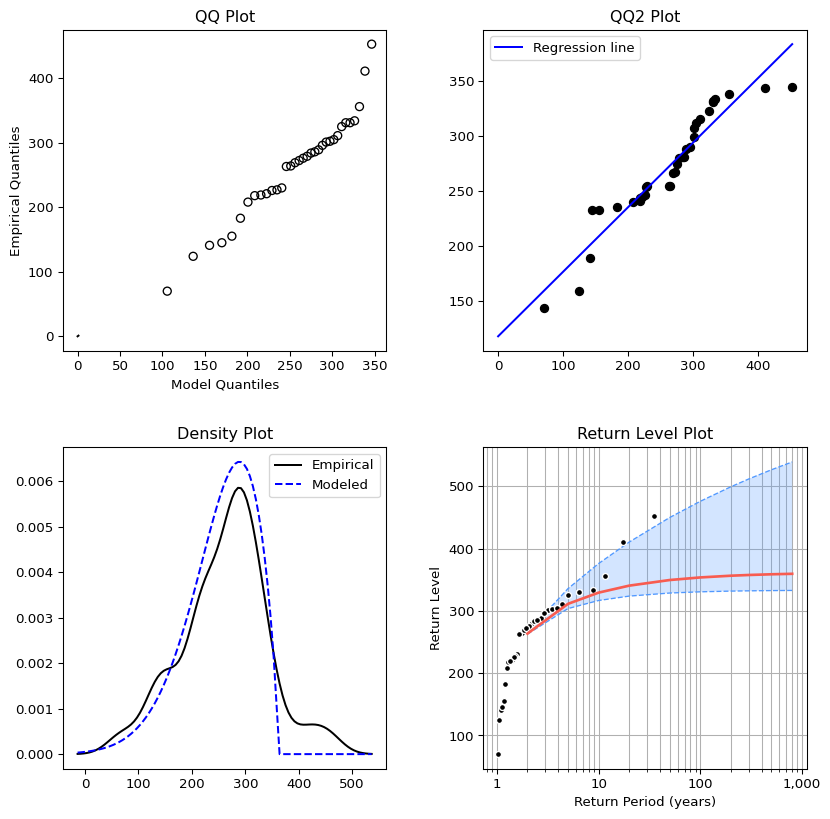

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_all(amax_values, model, shape, loc, scale, save_figure=False, filename='data_plot.png'):
    figsize = (10, 10)
    with plt.rc_context(rc=None):  # Replace with `pyextremes_rc` if needed
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=96, gridspec_kw={'wspace': 0.3, 'hspace': 0.3})
        ax = ax.flatten()

    # Generate QQ data
    model_qq, empirical_qq = get_qq_data(amax_values['Q'], shape, loc, scale)
    ax[0].scatter(model_qq, empirical_qq, facecolor='none', edgecolors='k')
    ax[0].plot([0, 1], [0, 1], c='k')  # Placeholder 1-1 line
    ax[0].set_title("QQ Plot")
    ax[0].set_xlabel("Model Quantiles")
    ax[0].set_ylabel("Empirical Quantiles")

    # Generate QQ2 data
    empirical_qq2, model_qq2, x_val, y_val = get_qq2_data(empirical_qq, amax_values['Q'], shape, loc, scale)
    ax[1].scatter(empirical_qq2, model_qq2, facecolor='black', edgecolors='k')
    ax[1].plot(x_val, y_val, 'b', label='Regression line')
    ax[1].set_title("QQ2 Plot")
    ax[1].legend()

    # Density plot
    points_emp, empirical_density, points_mod, model_density, num_samples_density, bw = density_data(amax_values, model)
    ax[2].plot(points_emp, empirical_density, 'k', label='Empirical')
    ax[2].plot(points_mod, model_density, 'b--', label='Modeled')
    ax[2].set_title("Density Plot")
    ax[2].legend()

    # Return level plot
    return_periods = np.array([2, 5, 10, 20, 50, 100, 200, 300, 500, 800])
    alpha = 0.95
    num_samples_return = 100
    model.plot_return_values(ax=ax[3], return_period=return_periods, alpha=alpha, n_samples=num_samples_return, return_period_size='365D')
    ax[3].set_title("Return Level Plot")
    ax[3].set_xlabel("Return Period (years)")
    ax[3].set_ylabel("Return Level")

    summary = model.get_summary(
        return_period=return_periods,
        alpha=alpha,
        n_samples=num_samples_return)

    print(summary)

    if save_figure:
        plt.savefig(filename, format='png', bbox_inches='tight', dpi=900)
    plt.show()


if __name__ == '__main__':
    """The following data is an example AMAX data come from one of the qauge station in Scotland"""
    """data = {
        'Year': [
            1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1995, 1996,
            1997, 1998, 1999, 2000, 2000, 2001, 2002, 2003, 2004, 2005,
            2005, 2006, 2007, 2008, 2009, 2010, 2010, 2011, 2012, 2013,
            2014, 2015
        ],
        'Q': [
            21.656, 5.549, 17.471, 19.597, 13.278, 24.612, 22.474, 1.993, 70.728, 39.268,
            22.992, 33.228, 32.107, 6.861, 55.083, 24.813, 55.21, 19.697, 17.771, 3.51,
            23.88, 18.129, 43.645, 26.923, 93.823, 3.964, 46.792, 20.971, 34.36, 19.84,
            31.733, 12.529
        ]
    }"""

    # Read the CSV file, skipping metadata lines and handling malformed rows
    file_path = r'/39121_gdf.csv'  # Modify with your actual file path

    # Read the file directly, skipping the first 21 metadata lines and handling malformed rows
    df = pd.read_csv(file_path, skiprows=21, header=None, on_bad_lines='skip')

    # The first column is the date, and the second column is the flow value
    df.columns = ['timestamp', 'flow']

    # Remove rows where flow is missing or cannot be converted to a number
    df = df[pd.to_numeric(df['flow'], errors='coerce').notna()]

    # Convert 'timestamp' to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Extract year from the timestamp
    df['Year'] = df['timestamp'].dt.year

    # Group by year and get the maximum flow (AMAX) for each year
    amax = df.groupby('Year')['flow'].max().reset_index()

    # Format the data as required
    data = {
        'Year': amax['Year'].tolist(),
        'Q': amax['flow'].tolist()
    }


    # Create a DataFrame
    amax_values = pd.DataFrame(data)

    # Set 'Year' as the index
    amax_values.set_index('Year', inplace=True)

    # Use the `fevd` function
    model, shape, loc, scale = fevd(amax_values)

    # Plot all
    plot_all(amax_values, model, shape, loc, scale, save_figure=True, filename='data_plot_2.png')
